In [0]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np
import sklearn
# featuretools for automated feature engineering
import featuretools as ft

# ignore warnings from pandas
import warnings
warnings.filterwarnings('ignore')

from FeatureSelector import FeatureSelector
import seaborn as sns
import datetime as dt

In [0]:
什么时候做好防控

# Are you going to die in COVID-19？ (Wensong Qiao)

#  Introduction

COVID-19 has spread in all the world. At the very begining time, COVID-19 was found at Wuhan,China. Only after a month, there is more than 80,000 infected persons in all the world. Therefore, what is the problem we care about most? For me, I just a conmmon people, not politicians, doctors, and officiers. I only care about my questions, that is if I get COVID-19, what's the probability that I will recover? What's the probability I will die? Therefore, I decide to make an predictive model to predict two problems? (1)The first is that given the personal who is already infected, predict if the person will die. (2) predict if the person will recover.  

This is a meaningful problem we need to solve, however, we still need to keep calm and go back to our machine learning methods.

Let's go back to our machine learning, for every machine learning problem, we can use the following process:  

(1) Understand the problem and the data      
(2) Data Acquisition  
(3) Exploratory Data Analysis  
(4) Feature Engineering   
(5) Baseline model       
(6) Improved model    
(7) Conculusion     

Therefore, this time, I prefer to use this process to do this project.

# 1.Understand the problem and the data

Goal: Predict if a infected person will recover or die   
Because it is a classification problem, we will consider the logistic regression, random forest, and XGBoosting. We do not consider neural network here, beacause this is a 'Spreadsheet' dataset, and our dataset is not large engough. 

# 2.Import Data

In [0]:
import os
os.getcwd() #get current work direction.
os.chdir('C:/Users/39377/Documents/GitHub/Walmart_MI_ML_interview_campus/data')

In [0]:
#Load Data
train_line_list = pd.read_csv('COVID19_line_list_data.csv')
train = train_line_list.sample(1085)
train_labels_death = train['death']
train_labels_recovered = train['recovered']
train = train.drop(columns = ['death','recovered'])

In [0]:
train = train.drop(columns =['link'])

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1085 entries, 27 to 1036
Data columns (total 18 columns):
id                       1085 non-null int64
case_in_country          888 non-null float64
reporting date           1084 non-null object
Unnamed: 3               0 non-null float64
summary                  1080 non-null object
location                 1085 non-null object
country                  1085 non-null object
gender                   902 non-null object
age                      843 non-null float64
symptom_onset            563 non-null object
If_onset_approximated    560 non-null float64
hosp_visit_date          507 non-null object
exposure_start           128 non-null object
exposure_end             341 non-null object
visiting Wuhan           1085 non-null int64
from Wuhan               1081 non-null float64
symptom                  270 non-null object
source                   1085 non-null object
dtypes: float64(5), int64(2), object(11)
memory usage: 161.1+ KB


In [21]:
train.shape

(1085, 24)

In [0]:
train = train.iloc[:,0:18]
train = train.drop('Unnamed: 3', axis=1)

In [5]:
train.head()

,id,case_in_country,reporting date,summary,location,country,gender,age,symptom_onset,If_onset_approximated,hosp_visit_date,exposure_start,exposure_end,visiting Wuhan,from Wuhan,symptom,source
713,714,23.0,02/04/20,new confirmed COVID-19 patient in Thailand: Th...,Thailand,Thailand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,NaN,Bangkok Post
429,430,4.0,1/25/2020,new confirmed COVID-19 patient in Malaysia: ma...,Johor,Malaysia,male,2.0,1/24/2020,1.0,NaN,NaN,NaN,0,0.0,NaN,Straits Times
684,685,28.0,2/23/2020,new confirmed COVID-19 patient in Taiwan: male...,Taiwan,Taiwan,male,55.0,NaN,NaN,NaN,NaN,NaN,0,0.0,throat discomfort,Taiwan CDC
144,145,NaN,1/25/2020,new confirmed imported COVID-19 pneumonia pati...,Yunnan,China,male,58.0,NaN,NaN,1/24/2020,01/09/20,1/20/2020,1,0.0,NaN,央视新闻
685,686,29.0,2/24/2020,new confirmed COVID-19 patient in Taiwan: male...,Taiwan,Taiwan,male,45.0,1/29/2020,0.0,NaN,NaN,NaN,0,0.0,physical discomfort,Taiwan CDC


# 3. EDA

## About COVID-19

## About Machine Learning

### (1).Missing Value

In [0]:
# Create an empty function
fs = FeatureSelector()

3 features with greater than 0.60 missing values.



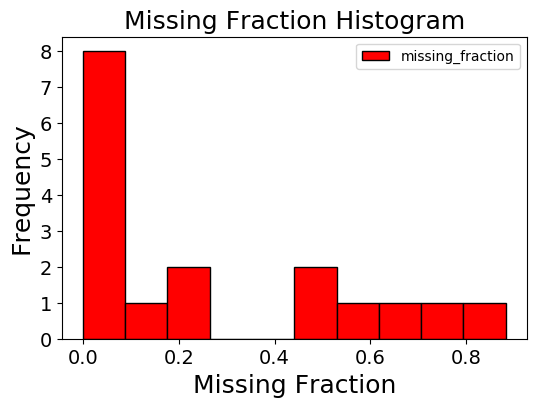

In [7]:
fs.identify_missing(train, 0.6)
fs.plot_missing()

### (2).Single Unique Value Features

0 features with a single unique value.



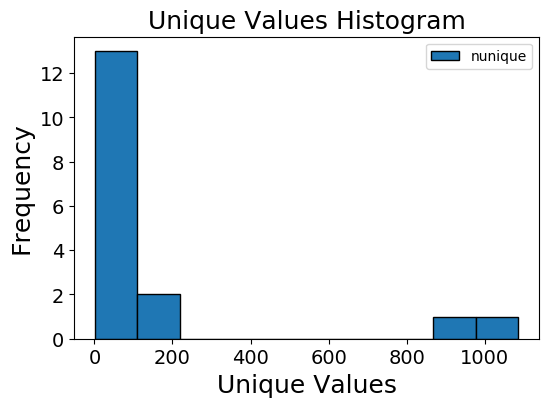

In [8]:
fs.identify_single_unique(train)
fs.plot_unique()

### (3).Collinear Features

In [9]:
fs.identify_collinear(train, 0.99)

0 features with a correlation greater than 0.99.



### (4).Check the class balance

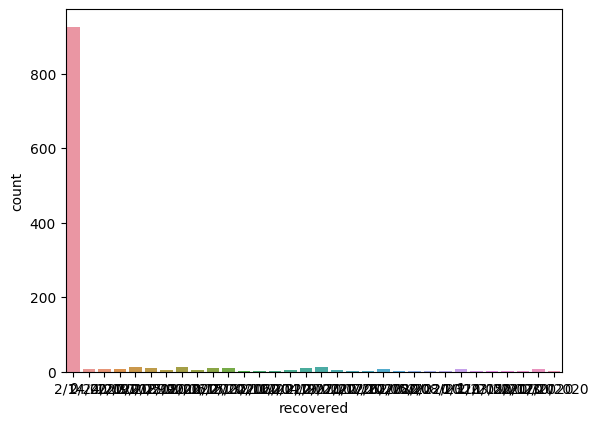

In [10]:
# Check if the data is balanced 
train_labels_recovered.value_counts()
sns.countplot(train_labels_recovered)

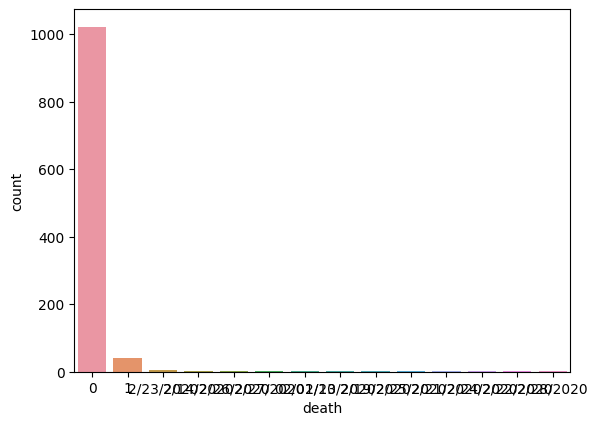

In [11]:
train_labels_recovered.value_counts()
sns.countplot(train_labels_death)

# 4.Feature Engineering

## (1)Add Features

Usually,in feature engineering, we need to create more new and efficient features.There are two ways, one is aggregation and another is transformation.Because I have limited domain knowledge of medical science, I woulf like to get as much information as possible, and then to select the efficient futures.

In [0]:
train['TimeToDiagnostic'] = pd.to_datetime(train['hosp_visit_date']) - pd.to_datetime(train['exposure_start'])
train['exposureTime'] = pd.to_datetime(train['exposure_end']) - pd.to_datetime(train['exposure_start'])
train['ExposureToSymptomc'] = pd.to_datetime(train['exposure_start']) - pd.to_datetime(train['exposure_start'])

In [0]:
cols = ['TimeToDiagnostic', 'exposureTime', 'ExposureToSymptomc']
for col in cols:
    train[col] = train[col].dt.days

In [14]:
# bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
train.head()

,id,case_in_country,reporting date,summary,location,country,gender,age,symptom_onset,If_onset_approximated,hosp_visit_date,exposure_start,exposure_end,visiting Wuhan,from Wuhan,symptom,source,TimeToDiagnostic,exposureTime,ExposureToSymptomc
713,714,23.0,02/04/20,new confirmed COVID-19 patient in Thailand: Th...,Thailand,Thailand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,NaN,Bangkok Post,NaN,NaN,NaN
429,430,4.0,1/25/2020,new confirmed COVID-19 patient in Malaysia: ma...,Johor,Malaysia,male,2.0,1/24/2020,1.0,NaN,NaN,NaN,0,0.0,NaN,Straits Times,NaN,NaN,NaN
684,685,28.0,2/23/2020,new confirmed COVID-19 patient in Taiwan: male...,Taiwan,Taiwan,male,55.0,NaN,NaN,NaN,NaN,NaN,0,0.0,throat discomfort,Taiwan CDC,NaN,NaN,NaN
144,145,NaN,1/25/2020,new confirmed imported COVID-19 pneumonia pati...,Yunnan,China,male,58.0,NaN,NaN,1/24/2020,01/09/20,1/20/2020,1,0.0,NaN,央视新闻,15.0,11.0,0.0
685,686,29.0,2/24/2020,new confirmed COVID-19 patient in Taiwan: male...,Taiwan,Taiwan,male,45.0,1/29/2020,0.0,NaN,NaN,NaN,0,0.0,physical discomfort,Taiwan CDC,NaN,NaN,NaN


## (2) Create dummy variables

In [0]:
cat_vars=['summary','location','country', 'gender', 'symptom', 'symptom_onset', 'hosp_visit_date','exposure_start','exposure_end','source']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(train[var], prefix=var)
    train_copy=pd.concat([train,cat_list],axis = 1)
  
data_vars=train.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

In [0]:
train_copy = train_copy.drop(cat_vars, axis=1)

## (3)Feature Selection

Usually, we do not want to use all the features. That is becuase unnecessary features decrease training speed, decrease model interpretability, and decrease generalization performance on the test set.

### I.Missing Value

In [17]:
fs.identify_missing(train_copy, 0.6)

4 features with greater than 0.60 missing values.



### II.Single Unique Value Features

A feature with only one unique value cannot be useful for machine learning because this feature has zero variance.

In [18]:
fs.identify_single_unique(train_copy)

1 features with a single unique value.



### III.Collinear Features

Collinear Features lead to decreased generalization performance on the test set due to high variance and less model interpretability.

In [19]:
fs.identify_collinear(train_copy, 0.99)

0 features with a correlation greater than 0.99.



### IV.Removing Features

In [20]:
features_identified = fs.check_identified()

4 features identified for removal


In [21]:
train_removed = fs.remove(train_copy, methods = 'all')

['missing', 'single_unique', 'collinear'] methods have been run


KeyError: ignored

In [0]:
train_removed.to_csv('train_removed.csv')

In [0]:
train_copy = train_removed

## (4)Handling Missing Data

In [0]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

In [25]:
imputer = imputer.fit(train_copy)
train_copy = imputer.transform(train_copy)

ValueError: ignored

In [0]:
train_copy[0]

array([ 3.93583000e+05,  1.44000000e+05,  3.01500000e+05,  1.55250000e+04,
        8.47400000e-03, -1.40880000e+04, -2.54000000e+03, -3.14300000e+03,
       -4.81300000e+03,  1.40000000e+01,  0.00000000e+00,  4.00000000e+00,
        1.50000000e+01,  6.35473732e-01,  2.07964174e-01,  7.11000000e-02,
        1.20800000e-01,  9.60800000e-01,  7.55200000e-01,  0.00000000e+00,
        0.00000000e+00,  2.41400000e-01,  1.25000000e-01,  1.66700000e-01,
        0.00000000e+00,  8.58000000e-02,  4.10000000e-03,  0.00000000e+00,
        4.30000000e-03,  7.69000000e-02,  2.00000000e+00, -1.66600000e+03,
        1.00000000e+00,  0.00000000e+00,  0.00000000e+00])

## (5) Scaling

In [26]:
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
train_copy_minmax = min_max_scaler.fit_transform(train_copy)

ValueError: ignored

In [0]:
train_copy_minmax[0]

array([0.82408702, 0.05263158, 0.09661017, 0.09618975, 0.10529551,
       0.63481092, 0.036665  , 0.83947086, 0.22458515, 0.21538462,
       0.        , 0.27272727, 0.65217391, 0.77741165, 0.23217548,
       0.0711    , 0.1208    , 0.9608    , 0.7552    , 0.        ,
       0.        , 0.2414    , 0.125     , 0.1667    , 0.        ,
       0.0858    , 0.0041    , 0.        , 0.00436992, 0.0769    ,
       0.08695652, 0.59066339, 1.        , 0.        , 0.        ])

## (6) Over-sampling using SMOTE

In [0]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(train_copy_minmax, train_labels, test_size=0.3, random_state=0)
columns = train_removed.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(os_data_y)
X_test = pd.DataFrame(data=X_test,columns=columns )
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['TARGET']==0]))
print("Number of subscription",len(os_data_y[os_data_y['TARGET']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['TARGET']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['TARGET']==1])/len(os_data_X))

length of oversampled data is  12934
Number of no subscription in oversampled data 6467
Number of subscription 6467
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


创建一个表比较各个model  Cofusion matirx

# (5)Baseline model

In [0]:
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt 

In [55]:
train_copy.head()

,id,case_in_country,age,If_onset_approximated,visiting Wuhan,from Wuhan,TimeToDiagnostic,exposureTime,ExposureToSymptomc,source_ABC,source_ABC News,source_Al Arabiya,source_Aljazeera,source_BBC,source_Bangkok Post,source_Bavaria Health Ministry,source_Beijing Municipal Health Commission,source_Bloomberg,source_CDC,source_CGTN,source_CNBC,source_CNN,source_Channel 3000,source_Channel News Asia,source_China Daily HK,source_Chongqing Municipal Health Commission,source_Daily HK,source_Department of Health,source_Fortune,source_Fox News,source_French Ministry of Health,source_Global News,source_Gov.UK,source_Government HK,source_Gulf News,source_HBL,source_HK World-Japan,source_Health Commission of Shanxi,source_Health Commission of Zhejiang Province,source_Iran Ministry of Health,...,source_National Post,source_Nikkei Asian Review,source_Nippon,source_Official Weibo of Shanghai Municipal Health Commission,source_Politico,source_Reuters,source_SBS,source_Shenzhen Municipal Health Commission,source_Shine,source_South China Morning Post,source_Straits Times,source_Suede Deutsche,source_Taiwan CDC,source_Taiwan MOH,source_Taiwan News,source_The Daily Beast,source_The Economic Times,source_The Guardian,source_The Hill,source_The Japan Times,source_The Local,source_The Mirror,source_The National,source_The Star Online,source_The Times of Israel,source_Thomson Reuters Foundation News,source_US News,source_Vietnam Insider,source_Vietnam News,source_Wa.de,source_Washington Examiner,source_Xin Hua Net,source_Yahoo News,source_Yonnhap News Agency,source_nice matin,source_rthk.hk,source_人民日报,source_人民日报官方微博,source_央视新闻,source_新浪
621,622,79.0,22.0,NaN,0,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1013,1014,18.0,30.0,NaN,0,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
394,395,159.0,45.0,0.0,0,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
296,297,61.0,75.0,0.0,0,0.0,NaN,8.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
112,113,NaN,67.0,0.0,0,1.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [0]:
train_copy.drop('reporting date', axis=1, inplace=True)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train_copy, train_labels_death, test_size=0.33, random_state=42)

### Logistic

In [54]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

ValueError: ignored

In [0]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.69


In [0]:
from sklearn.metrics import confusion_matrix
res = confusion_matrix(y_test, y_pred)
print(res)

[[1910  854]
 [  83  153]]


In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.69      0.80      2764
           1       0.15      0.65      0.25       236

    accuracy                           0.69      3000
   macro avg       0.56      0.67      0.52      3000
weighted avg       0.89      0.69      0.76      3000



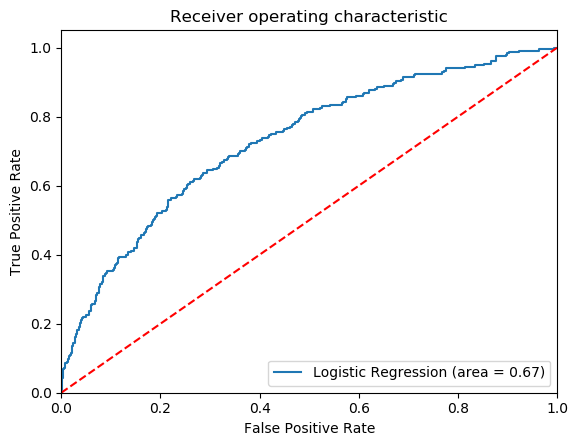

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt 
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
random_forest.fit(os_data_X, os_data_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=50, verbose=1,
                       warm_start=False)

In [0]:
y_pred = random_forest.predict(X_test)
print('Accuracy of random forest classifier on test set: {:.2f}'.format(random_forest.score(X_test, y_test)))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of random forest classifier on test set: 0.91


In [0]:
res = confusion_matrix(y_test, pd.DataFrame(y_pred))
print(res)

[[2719   45]
 [ 223   13]]


In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      2764
           1       0.22      0.06      0.09       236

    accuracy                           0.91      3000
   macro avg       0.57      0.52      0.52      3000
weighted avg       0.87      0.91      0.89      3000



[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


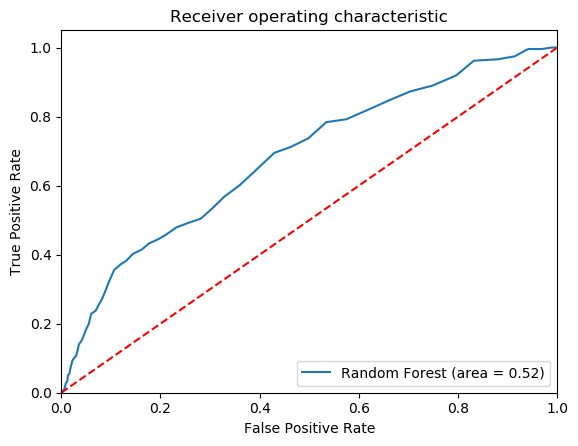

In [0]:
random_forest_roc_auc = roc_auc_score(y_test, random_forest.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, random_forest.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % random_forest_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# (6)Improved Model

In [0]:
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [0]:
##训练部分
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=100, learning_rate=0.05, subsample=0.5)
xgb_model.fit(X_train, y_train)
##预测部分
y_pred = xgb_model.predict(X_test)

In [70]:
print('Accuracy of XGBoosting classifier on test set: {:.2f}'.format(xgb_model.score(X_test, y_test)))

Accuracy of XGBoosting classifier on test set: 0.97


In [71]:
confusion_matrix_xgb = confusion_matrix(y_test, y_pred)
print(confusion_matrix_xgb)

[[343   1]
 [ 11   4]]


In [72]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       344
           1       0.80      0.27      0.40        15

    accuracy                           0.97       359
   macro avg       0.88      0.63      0.69       359
weighted avg       0.96      0.97      0.96       359



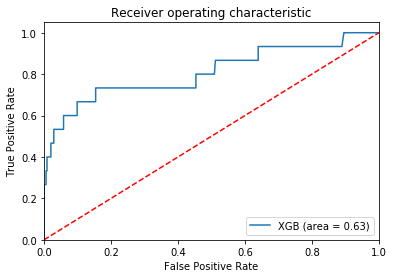

In [75]:
xgb_roc_auc = roc_auc_score(y_test, xgb_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test,xgb_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='XGB (area = %0.2f)' % xgb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [0]:
# k-fold
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(xgb_model, X_train, y_train, cv=kfold)

In [79]:
print(results)

[0.97260274 0.98630137 0.97260274 0.97260274 0.97260274 1.
 0.94444444 0.94444444 0.93055556 0.95833333]


In [0]:
# Hyperparameter tuning
from sklearn.grid_search import GridSearchCV   

保存最好模型

In [0]:
# save model to file
pickle.dump(model, open("pima.pickle.dat", "wb"))

# (7)Conclusion

improvement
（1）for Hyperparameter tuning, we have Manual,Grid Search,Random search,Automated Hyperparameter Tuning
(2) for missing value, we have MAR,MCAR,and MNAR.We may try use KNN or EM.